In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
from point_configuration import PointConfiguration
from basics import get_edm

## Setup
n = 10
d = 3
e = np.ones(n)
p = PointConfiguration(n, d)
p.set_points(mode='normal')

In [12]:
from semidefinite import reconstruct_sdp
W = np.ones([n,n])
lamda = 1000
Xhat, EDMbest = reconstruct_sdp(p.edm, W, lamda)

total cost: 24.344093192218605
trace of H: 24.3360936703
other cost: 0.469459925657


NameError: name 'p' is not defined

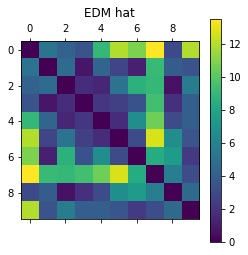

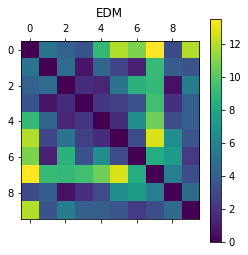

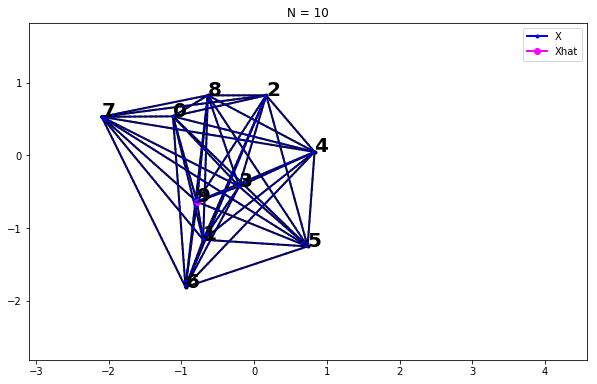

rmse: 7.61375739744e-06


In [10]:
from plots_cti import plot_point_sets, plot_matrix
plot_matrix(EDMbest, 'EDM hat')
plot_matrix(p.edm, 'EDM')
plot_point_sets([p.points,Xhat],names=['X','Xhat'],display_lines=True)
print('rmse:',np.linalg.norm(p.points-Xhat)/np.sqrt(len(Xhat)))